<a href="https://colab.research.google.com/github/Techingopochtli/Prophet_for_mexican_stock_market/blob/main/prophet_BMVV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary packages

In [ ]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from prophet import Prophet


from sklearn.metrics import mean_squared_error, mean_absolute_error


## Loading and exploring data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datos_historicos_1990-2023.csv")

# transforming "Fecha" column to datetime type
data["Fecha"] = pd.to_datetime(data["Fecha"],dayfirst= True)
data.head()

,Fecha,Cierre,Apertura,Máximo,Mínimo,Vol.,% var.
0,2023-05-26,36.90,36.89,37.50,36.71,906.64K,-0.03%
1,2023-05-25,36.91,36.62,36.99,36.07,516.84K,-0.08%
2,2023-05-24,36.94,36.73,37.08,35.73,1.01M,0.79%
3,2023-05-23,36.65,37.21,37.21,36.51,965.24K,-0.92%
4,2023-05-22,36.99,37.40,37.54,36.52,1.66M,-1.10%


In [ ]:
data.describe()

,Cierre,Apertura,Máximo,Mínimo
count,3761.000000,3761.000000,3761.000000,3761.000000
mean,29.743150,29.765590,30.181343,29.313503
std,9.436456,9.459297,9.589040,9.318389
min,5.889000,5.536000,6.146000,5.536000
25%,24.559000,24.530000,24.957000,24.250000
50%,30.100000,30.070000,30.450000,29.700000
75%,36.650000,36.730000,37.240000,36.070000
max,51.950000,51.410000,52.170000,50.420000


In [ ]:
print("Number of rows in data: \n", data.count())

Number of rows in data: 
 Fecha       3761
Cierre      3761
Apertura    3761
Máximo      3761
Mínimo      3761
Vol.        3760
% var.      3761
dtype: int64


In [ ]:
data.isnull().sum()

Fecha       0
Cierre      0
Apertura    0
Máximo      0
Mínimo      0
Vol.        1
% var.      0
dtype: int64

In [ ]:
data.columns

Index(['Fecha', 'Cierre', 'Apertura', 'Máximo', 'Mínimo', 'Vol.', '% var.'], dtype='object')

## Cleaning dataset

In [ ]:
new_column_names = {
    "Fecha": "date",
    "Cierre": "close",
    "Apertura": "open",
    "Máximo": "max",
    "Mínimo": "min",
    "Vol.": "vol",
    "% var.": "var"
}

In [ ]:
data.rename(columns = new_column_names, inplace = True)

data.columns

Index(['date', 'close', 'open', 'max', 'min', 'vol', 'var'], dtype='object')

In [ ]:
data[data["vol"].isnull()]

,date,close,open,max,min,vol,var
744,2020-06-15,43.95,43.015,44.19,42.03,NaN,1.57%


In [ ]:
data = data.dropna(axis=0, how="any") # Dropping rows with any null value

In [ ]:
data.dtypes

date     datetime64[ns]
close           float64
open            float64
max             float64
min             float64
vol              object
var              object
dtype: object

In [ ]:
def transform_volume(value):
  """
  Expects a string of the type '1.6K' or '1.6M'
  returns the corresponding float value e.g.
  1.6K => 1600.0
  1.6M => 1600000.0
  1.6  => 1.6
  """
  suffix = value[-1]
  quantity = float(value[:-1])
  multiplier = 1
  if suffix == 'K':
      multiplier = 1000
  elif suffix == 'M':
      multiplier = 1000000
  else:
      quantity = float(value)

  return quantity * multiplier

In [ ]:
def transform_var(value):
  """
  Removes percent sign (%) at the end of string
  """
  return float(str(value)[:-1])

In [ ]:
transformed_vol = data["vol"].apply(str)

volume_to_float = transformed_vol.apply(transform_volume)

In [ ]:
data["var"] = data["var"].apply(transform_var)

In [ ]:
print(volume_to_float)

0         906640.0
1         516840.0
2        1010000.0
3         965240.0
4        1660000.0
           ...    
3756     5190000.0
3757     6930000.0
3758     7890000.0
3759    18130000.0
3760    15920000.0
Name: vol, Length: 3760, dtype: float64


In [ ]:
data["vol"] = volume_to_float

In [ ]:
data.head()

,date,close,open,max,min,vol,var
0,2023-05-26,36.90,36.89,37.50,36.71,906640.0,-0.03
1,2023-05-25,36.91,36.62,36.99,36.07,516840.0,-0.08
2,2023-05-24,36.94,36.73,37.08,35.73,1010000.0,0.79
3,2023-05-23,36.65,37.21,37.21,36.51,965240.0,-0.92
4,2023-05-22,36.99,37.40,37.54,36.52,1660000.0,-1.10


In [ ]:
data = pd.concat(
      [
          data,
          data["date"].dt.day_name()
      ],
      axis=1
    )

In [ ]:
data.head()

,date,close,open,max,min,vol,var,date
0,2023-05-26,36.90,36.89,37.50,36.71,906640.0,-0.03,Friday
1,2023-05-25,36.91,36.62,36.99,36.07,516840.0,-0.08,Thursday
2,2023-05-24,36.94,36.73,37.08,35.73,1010000.0,0.79,Wednesday
3,2023-05-23,36.65,37.21,37.21,36.51,965240.0,-0.92,Tuesday
4,2023-05-22,36.99,37.40,37.54,36.52,1660000.0,-1.10,Monday


In [ ]:
data.set_axis(
    ["date", "close", "open", "max", "min", "vol", "var", "day_name"],
    axis="columns",
    inplace=True
  )

<ipython-input-104-3884d4e8454f>:1: FutureWarning:

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead



In [ ]:
data = data[
      data["day_name"].isin(["Monday","Tuesday","Wednesday","Thursday","Friday"]) # Including only weekdays
    ]

In [ ]:
data.head(20)

,date,close,open,max,min,vol,var,day_name
0,2023-05-26,36.90,36.89,37.50,36.71,906640.0,-0.03,Friday
1,2023-05-25,36.91,36.62,36.99,36.07,516840.0,-0.08,Thursday
2,2023-05-24,36.94,36.73,37.08,35.73,1010000.0,0.79,Wednesday
3,2023-05-23,36.65,37.21,37.21,36.51,965240.0,-0.92,Tuesday
4,2023-05-22,36.99,37.40,37.54,36.52,1660000.0,-1.10,Monday
5,2023-05-19,37.40,37.70,38.04,37.32,1110000.0,-0.58,Friday
6,2023-05-18,37.62,37.93,37.98,37.18,719680.0,-0.13,Thursday
7,2023-05-17,37.67,38.10,38.12,37.52,439740.0,-1.15,Wednesday
8,2023-05-16,38.11,38.10,38.15,37.80,654560.0,0.00,Tuesday
9,2023-05-15,38.11,38.26,38.31,38.05,1110000.0,0.00,Monday


## Data visualization

In [ ]:
data.rename_axis("index", inplace=True)

In [ ]:
data.sort_values(by="index", ascending=False, inplace=True)

In [ ]:
data.head()

,date,close,open,max,min,vol,var,day_name
index,,,,,,,,
3760,2008-06-16,15.589,15.723,16.180,15.437,15920000.0,-0.79,Monday
3759,2008-06-17,14.779,15.627,15.666,14.675,18130000.0,-5.20,Tuesday
3758,2008-06-18,14.808,14.865,14.960,14.389,7890000.0,0.20,Wednesday
3757,2008-06-19,14.808,14.789,15.132,14.503,6930000.0,0.00,Thursday
3756,2008-06-20,15.122,14.856,15.189,14.770,5190000.0,2.12,Friday


In [ ]:
data.tail()

,date,close,open,max,min,vol,var,day_name
index,,,,,,,,
4,2023-05-22,36.99,37.40,37.54,36.52,1660000.0,-1.10,Monday
3,2023-05-23,36.65,37.21,37.21,36.51,965240.0,-0.92,Tuesday
2,2023-05-24,36.94,36.73,37.08,35.73,1010000.0,0.79,Wednesday
1,2023-05-25,36.91,36.62,36.99,36.07,516840.0,-0.08,Thursday
0,2023-05-26,36.90,36.89,37.50,36.71,906640.0,-0.03,Friday


In [ ]:
fig = go.Figure(data=[go.Scatter(x=data["date"], y=data["close"])]) # Visualization of the closing price vs time

fig.update_layout(
    title="Value on close",
    xaxis_title="Date",
    yaxis_title="Close (Pesos)",
)

fig.show()

In [ ]:
fig = go.Figure(data=[go.Scatter(x=data["date"], y=data["open"])]) # Visualization of open price vs time

fig.update_layout(
    title="Value at the start of day",
    xaxis_title="Date",
    yaxis_title="Open (Pesos)",
)

fig.show()

In [ ]:
fig = go.Figure(data=[go.Scatter(x=data["date"], y=data["max"])]) # Visualization of the maximum price along the day

fig.update_layout(
    title="Max value during the day",
    xaxis_title="Date",
    yaxis_title="Max (Pesos)",
)

fig.show()

In [ ]:
fig = go.Figure(data=[go.Scatter(x=data["date"], y=data["min"])]) # Visualization of the minimum price along the day

fig.update_layout(
    title="Min value during the day",
    xaxis_title="Date",
    yaxis_title="Min (Pesos)",
)

fig.show()

In [ ]:
# Japanese candlestick graph shows the rising or decreasing tendency during the day
fig = go.Figure(
    data=[
        go.Candlestick(
            x=data["date"],
            open=data["open"],
            high=data["max"],
            low=data["min"],
            close=data["close"]
            )
        ]
    )

fig.update_layout(
    title="Japanese Candlestick Graph",
    xaxis_title="Date",
    yaxis_title="Action Value (Pesos)",
)

fig.show()

## Getting training and testing datasets

In [ ]:
row_numbers = data.index.tolist()[::-1]

In [ ]:
data["row_number"] = row_numbers

In [ ]:
data.head()

,date,close,open,max,min,vol,var,day_name,row_number
index,,,,,,,,,
3760,2008-06-16,15.589,15.723,16.180,15.437,15920000.0,-0.79,Monday,0
3759,2008-06-17,14.779,15.627,15.666,14.675,18130000.0,-5.20,Tuesday,1
3758,2008-06-18,14.808,14.865,14.960,14.389,7890000.0,0.20,Wednesday,2
3757,2008-06-19,14.808,14.789,15.132,14.503,6930000.0,0.00,Thursday,3
3756,2008-06-20,15.122,14.856,15.189,14.770,5190000.0,2.12,Friday,4


In [ ]:
data.tail()

,date,close,open,max,min,vol,var,day_name,row_number
index,,,,,,,,,
4,2023-05-22,36.99,37.40,37.54,36.52,1660000.0,-1.10,Monday,3756
3,2023-05-23,36.65,37.21,37.21,36.51,965240.0,-0.92,Tuesday,3757
2,2023-05-24,36.94,36.73,37.08,35.73,1010000.0,0.79,Wednesday,3758
1,2023-05-25,36.91,36.62,36.99,36.07,516840.0,-0.08,Thursday,3759
0,2023-05-26,36.90,36.89,37.50,36.71,906640.0,-0.03,Friday,3760


In [ ]:
# Column to indicate if row belongs to training or test set

data["is_training"] = data["row_number"].apply(lambda row: 1 if row < 3564 else 0)

In [ ]:
data.head()

,date,close,open,max,min,vol,var,day_name,row_number,is_training
index,,,,,,,,,,
3760,2008-06-16,15.589,15.723,16.180,15.437,15920000.0,-0.79,Monday,0,1
3759,2008-06-17,14.779,15.627,15.666,14.675,18130000.0,-5.20,Tuesday,1,1
3758,2008-06-18,14.808,14.865,14.960,14.389,7890000.0,0.20,Wednesday,2,1
3757,2008-06-19,14.808,14.789,15.132,14.503,6930000.0,0.00,Thursday,3,1
3756,2008-06-20,15.122,14.856,15.189,14.770,5190000.0,2.12,Friday,4,1


In [ ]:
data.tail()

,date,close,open,max,min,vol,var,day_name,row_number,is_training
index,,,,,,,,,,
4,2023-05-22,36.99,37.40,37.54,36.52,1660000.0,-1.10,Monday,3756,0
3,2023-05-23,36.65,37.21,37.21,36.51,965240.0,-0.92,Tuesday,3757,0
2,2023-05-24,36.94,36.73,37.08,35.73,1010000.0,0.79,Wednesday,3758,0
1,2023-05-25,36.91,36.62,36.99,36.07,516840.0,-0.08,Thursday,3759,0
0,2023-05-26,36.90,36.89,37.50,36.71,906640.0,-0.03,Friday,3760,0


In [ ]:
fig = go.Figure() # Visualization of the closing price vs time

fig.add_trace(
    go.Scatter(
        x=data["date"][data["is_training"]==1],
        y=data["close"][data["is_training"]==1],
        mode='markers+lines',
        name='training data'
        )
    )

fig.add_trace(
    go.Scatter(
        x=data["date"][data["is_training"]==0],
        y=data["close"][data["is_training"]==0],
        mode='markers+lines',
        name='test data'
        )
    )

fig.update_layout(
    title="Training and test set",
    xaxis_title="Date",
    yaxis_title="Close (Pesos)",
)

fig.show()

## Model evaluation

In [ ]:
training_data = data[data["is_training"] == 1][["date", "close"]]
test_data = data[data["is_training"] == 0][["date", "close"]]

In [ ]:
train_data_prophet = training_data.reset_index(drop=True) \
    .rename(
        columns={
            "date":"ds",
            "close":"y"
            }
        )

In [ ]:
train_data_prophet.head()

,ds,y
0,2008-06-16,15.589
1,2008-06-17,14.779
2,2008-06-18,14.808
3,2008-06-19,14.808
4,2008-06-20,15.122


In [ ]:
%%time
model = Prophet()
model.fit(train_data_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnpn56mrv/j9_bnpwc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnpn56mrv/vn4kh521.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48519', 'data', 'file=/tmp/tmpnpn56mrv/j9_bnpwc.json', 'init=/tmp/tmpnpn56mrv/vn4kh521.json', 'output', 'file=/tmp/tmpnpn56mrv/prophet_modelpts81l41/prophet_model-20230606032520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:25:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 428 ms, sys: 16.9 ms, total: 445 ms
Wall time: 2.76 s


In [ ]:
test_data_prophet = test_data.reset_index(drop=True) \
    .rename(
        columns={
            "date":"ds",
            "close":"y"
            }
        )

forecasted_close_data = model.predict(test_data_prophet)

In [ ]:
forecasted_close_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-12,41.031623,37.371545,43.976764,41.031623,41.031623,-0.455524,-0.455524,-0.455524,-0.879316,-0.879316,-0.879316,0.423792,0.423792,0.423792,0.0,0.0,0.0,40.576099
1,2022-08-15,41.025592,37.443094,43.605922,41.025592,41.025592,-0.525420,-0.525420,-0.525420,-0.918416,-0.918416,-0.918416,0.392996,0.392996,0.392996,0.0,0.0,0.0,40.500172
2,2022-08-16,41.023582,37.232479,43.712399,41.023582,41.023582,-0.503364,-0.503364,-0.503364,-0.882429,-0.882429,-0.882429,0.379065,0.379065,0.379065,0.0,0.0,0.0,40.520218
3,2022-08-17,41.021571,37.418855,43.594192,41.021571,41.021571,-0.520497,-0.520497,-0.520497,-0.884724,-0.884724,-0.884724,0.364227,0.364227,0.364227,0.0,0.0,0.0,40.501074
4,2022-08-18,41.019561,37.299275,43.518912,41.019561,41.019561,-0.530363,-0.530363,-0.530363,-0.879406,-0.879406,-0.879406,0.349043,0.349043,0.349043,0.0,0.0,0.0,40.489198


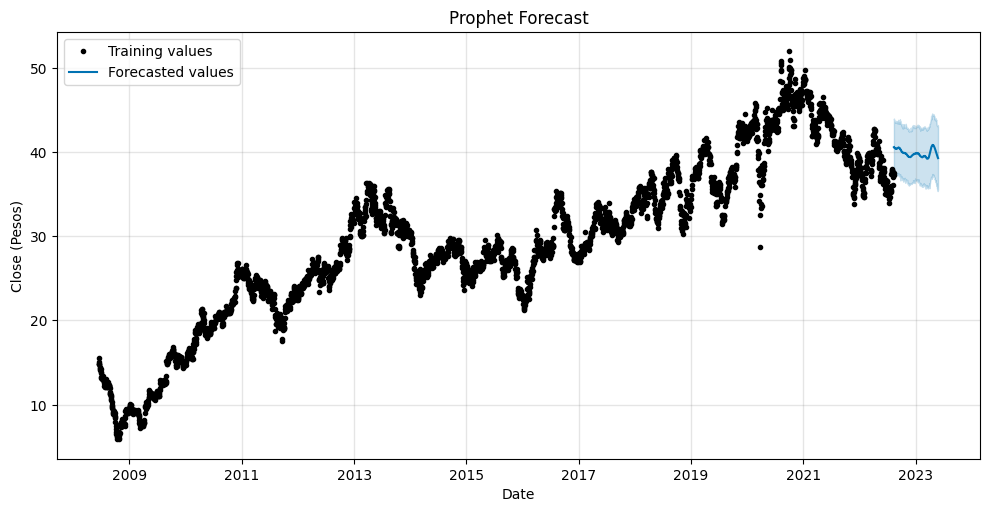

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

fig = model.plot(forecasted_close_data, ax=ax)

ax.set_title("Prophet Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Close (Pesos)")

ax.legend(["Training values", "Forecasted values"])

plt.show()

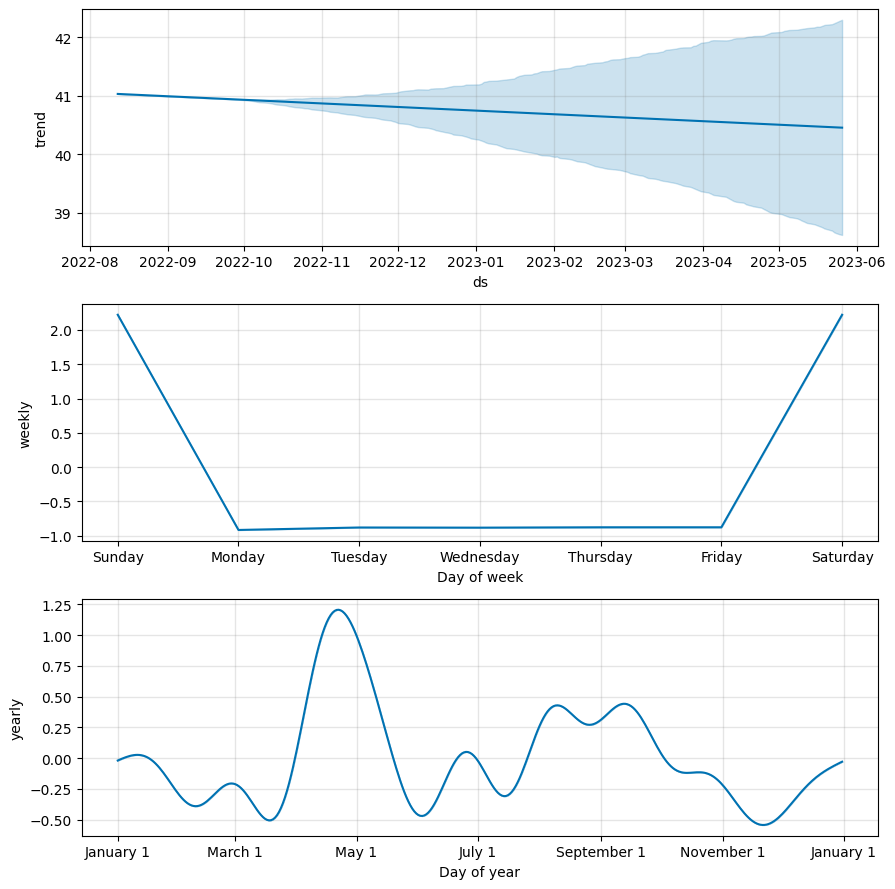

In [ ]:
fig = model.plot_components(forecasted_close_data)

plt.show()

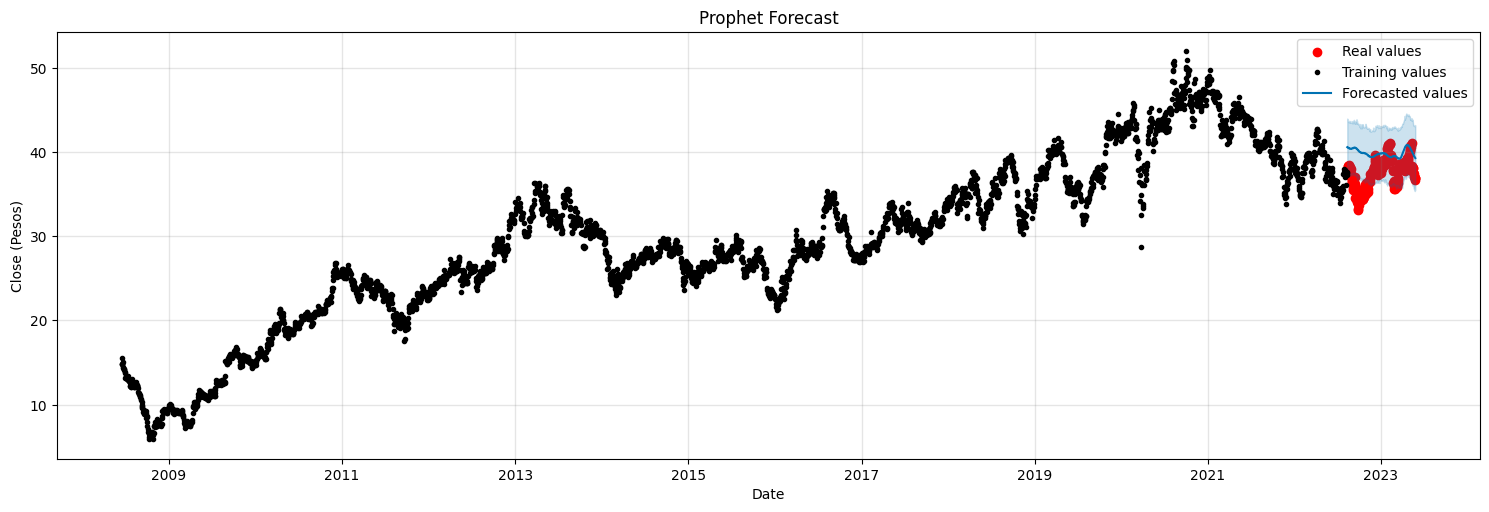

In [ ]:
# Plot the forecast with the real values

f, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_data["date"], test_data["close"], color='r')

fig = model.plot(forecasted_close_data, ax=ax)

ax.set_title("Prophet Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Close (Pesos)")

ax.legend(["Real values", "Training values", "Forecasted values"])

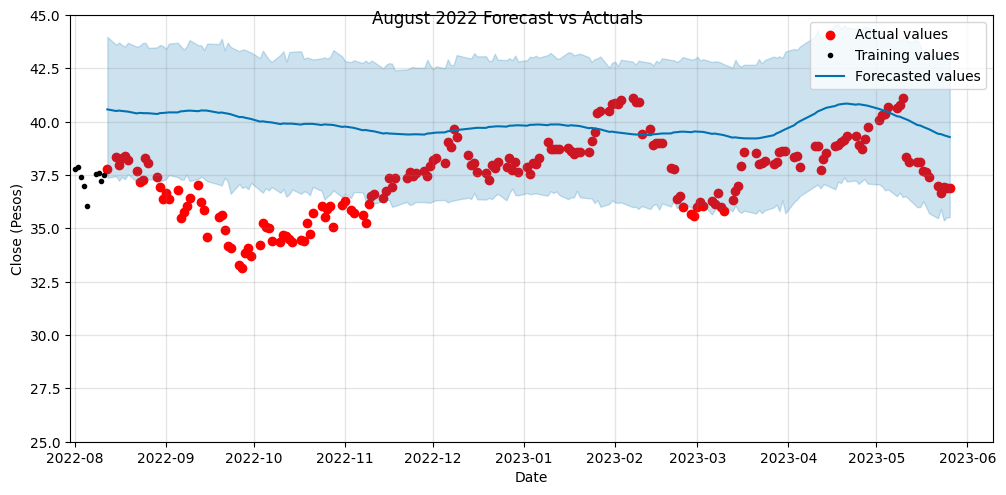

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(test_data["date"], test_data["close"], color='r')

fig = model.plot(forecasted_close_data, ax=ax)

ax.set_xbound(lower=19203.25, upper= 19517.75)

ax.set_ylim(25, 45)

plot = plt.suptitle("August 2022 Forecast vs Actuals")

ax.set_xlabel("Date")
ax.set_ylabel("Close (Pesos)")

ax.legend(["Actual values", "Training values", "Forecasted values"])

## Model evaluation with metrics

In [ ]:
np.sqrt(
    mean_squared_error(y_true=test_data["close"],
    y_pred=forecasted_close_data["yhat"])
    )

3.00726867440034

In [ ]:
mean_absolute_error(
    y_true=test_data["close"],
    y_pred=forecasted_close_data["yhat"]
    )

2.5429104856485045

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(
    y_true=test_data["close"],
    y_pred=forecasted_close_data["yhat"]
    )

6.98852277598713

# Making predictions

In [ ]:
future = model.make_future_dataframe(periods=197, freq='D',  include_history=True) # Create a dataframe to predict up to may 2030

In [ ]:
future.head(10)

,ds
0,2008-06-16
1,2008-06-17
2,2008-06-18
3,2008-06-19
4,2008-06-20
5,2008-06-23
6,2008-06-24
7,2008-06-25
8,2008-06-26
9,2008-06-27


In [ ]:
future.tail(10)

,ds
3750,2023-02-15
3751,2023-02-16
3752,2023-02-17
3753,2023-02-18
3754,2023-02-19
3755,2023-02-20
3756,2023-02-21
3757,2023-02-22
3758,2023-02-23
3759,2023-02-24


In [ ]:
predicted_values = model.predict(future) # Validating we only make predictions for week days

days_predicted= predicted_values["ds"].dt.day_name()

days_predicted.head(10)

0       Monday
1      Tuesday
2    Wednesday
3     Thursday
4       Friday
5       Monday
6      Tuesday
7    Wednesday
8     Thursday
9       Friday
Name: ds, dtype: object

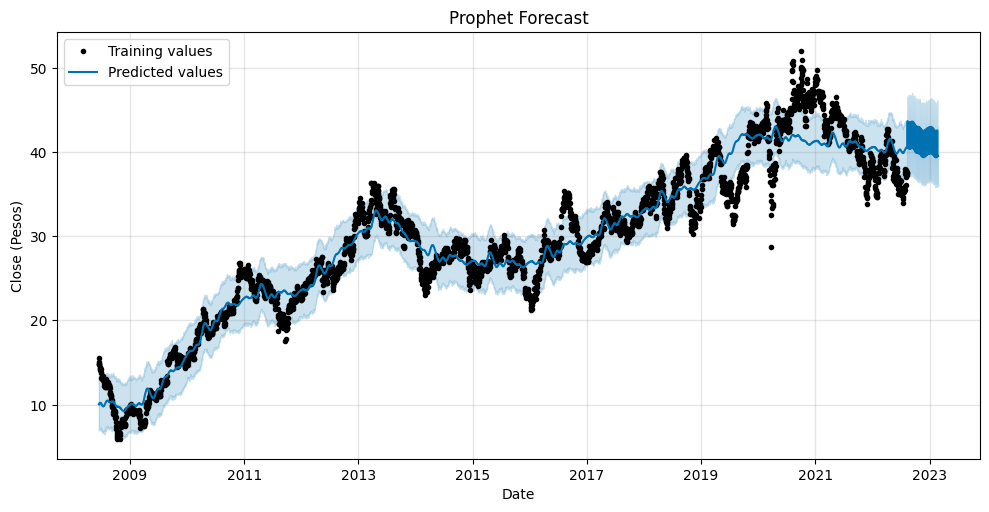

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

fig = model.plot(predicted_values, ax=ax)

ax.set_title("Prophet Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Close (Pesos)")

ax.legend(["Training values", "Predicted values"])

In [ ]:
predicted_values.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3750,2023-02-15,40.655669,35.876816,42.980976,39.901615,41.558839,-1.238400,-1.238400,-1.238400,-0.884724,-0.884724,-0.884724,-0.353677,-0.353677,-0.353677,0.0,0.0,0.0,39.417268
3751,2023-02-16,40.653658,36.019980,42.831841,39.897395,41.562869,-1.219691,-1.219691,-1.219691,-0.879406,-0.879406,-0.879406,-0.340285,-0.340285,-0.340285,0.0,0.0,0.0,39.433967
3752,2023-02-17,40.651648,36.135299,42.754867,39.882037,41.568415,-1.204931,-1.204931,-1.204931,-0.879316,-0.879316,-0.879316,-0.325614,-0.325614,-0.325614,0.0,0.0,0.0,39.446717
3753,2023-02-18,40.649637,39.273215,45.762824,39.874731,41.573961,1.912064,1.912064,1.912064,2.222144,2.222144,2.222144,-0.310081,-0.310081,-0.310081,0.0,0.0,0.0,42.561701
3754,2023-02-19,40.647627,39.170049,46.128442,39.870595,41.579507,1.928018,1.928018,1.928018,2.222146,2.222146,2.222146,-0.294128,-0.294128,-0.294128,0.0,0.0,0.0,42.575645
3755,2023-02-20,40.645616,35.908606,42.832435,39.861481,41.588028,-1.196634,-1.196634,-1.196634,-0.918416,-0.918416,-0.918416,-0.278218,-0.278218,-0.278218,0.0,0.0,0.0,39.448983
3756,2023-02-21,40.643606,36.011545,43.051552,39.855306,41.592992,-1.145248,-1.145248,-1.145248,-0.882429,-0.882429,-0.882429,-0.262820,-0.262820,-0.262820,0.0,0.0,0.0,39.498358
3757,2023-02-22,40.641595,36.017705,42.661326,39.849130,41.602832,-1.133122,-1.133122,-1.133122,-0.884724,-0.884724,-0.884724,-0.248398,-0.248398,-0.248398,0.0,0.0,0.0,39.508474
3758,2023-02-23,40.639585,36.176032,42.789375,39.832177,41.613443,-1.114810,-1.114810,-1.114810,-0.879406,-0.879406,-0.879406,-0.235404,-0.235404,-0.235404,0.0,0.0,0.0,39.524775
3759,2023-02-24,40.637574,36.015292,43.076216,39.825011,41.620933,-1.103577,-1.103577,-1.103577,-0.879316,-0.879316,-0.879316,-0.224261,-0.224261,-0.224261,0.0,0.0,0.0,39.533997


## Covid depression

Assuming the covid pandemic started in 01-03-2020, we see that the covid depression ended around 01-05-2020

In [ ]:
def is_covid_depression(date):
  COVID_START_DATE = pd.to_datetime("01-03-2020", dayfirst=True)
  COVID_DEPRESSION_END_DATE = pd.to_datetime("01-05-2020", dayfirst=True)

  return 1 if date > COVID_START_DATE and date < COVID_DEPRESSION_END_DATE else 0


In [ ]:
train_data_prophet["is_covid_depression"] = train_data_prophet["ds"].apply(is_covid_depression)

test_data_prophet["is_covid_depression"] = test_data_prophet["ds"].apply(is_covid_depression)

In [ ]:
covid_model = Prophet()

covid_model.add_regressor("is_covid_depression")

covid_model.fit(train_data_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnpn56mrv/w6a2ybyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnpn56mrv/27s3gowv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52542', 'data', 'file=/tmp/tmpnpn56mrv/w6a2ybyl.json', 'init=/tmp/tmpnpn56mrv/27s3gowv.json', 'output', 'file=/tmp/tmpnpn56mrv/prophet_modelkd1htbmk/prophet_model-20230606032532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:25:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:25:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecasted_close_data = covid_model.predict(test_data_prophet)

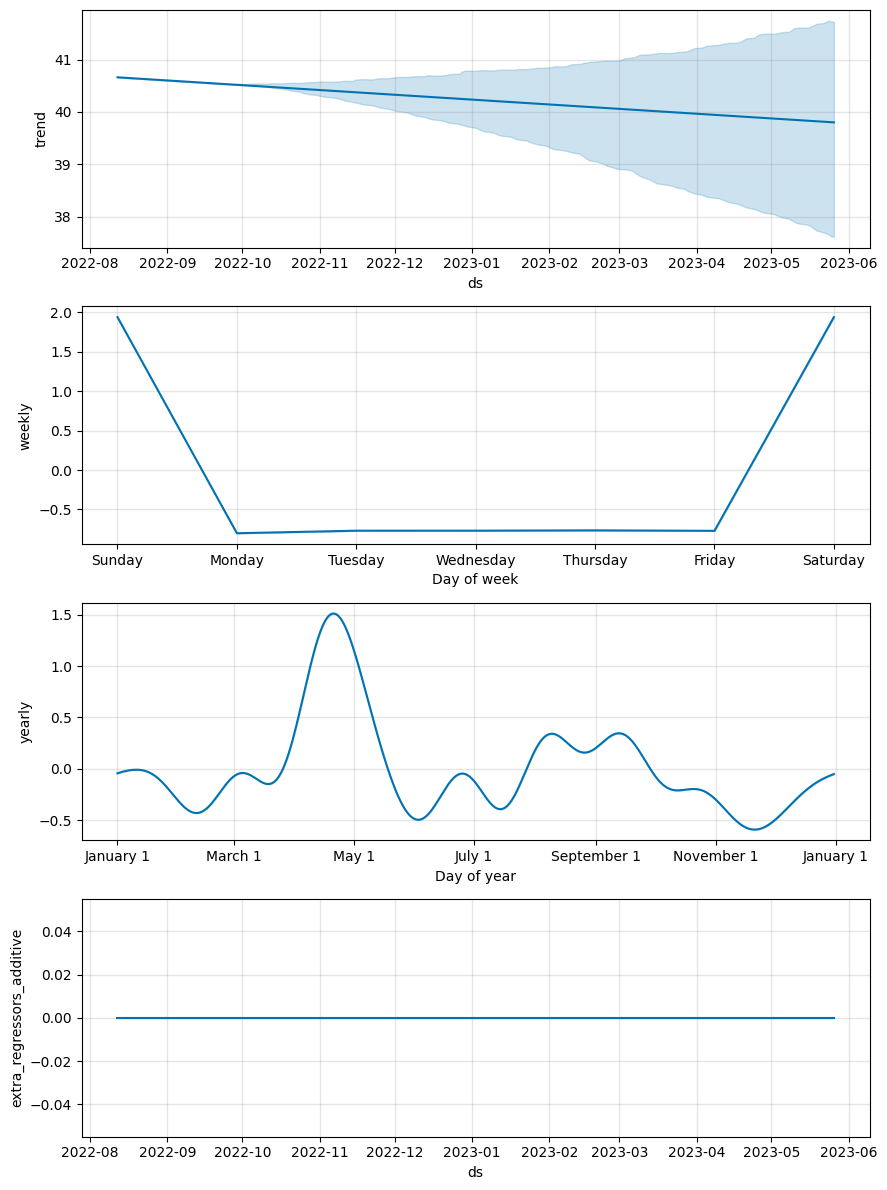

In [ ]:
fig = covid_model.plot_components(forecasted_close_data)

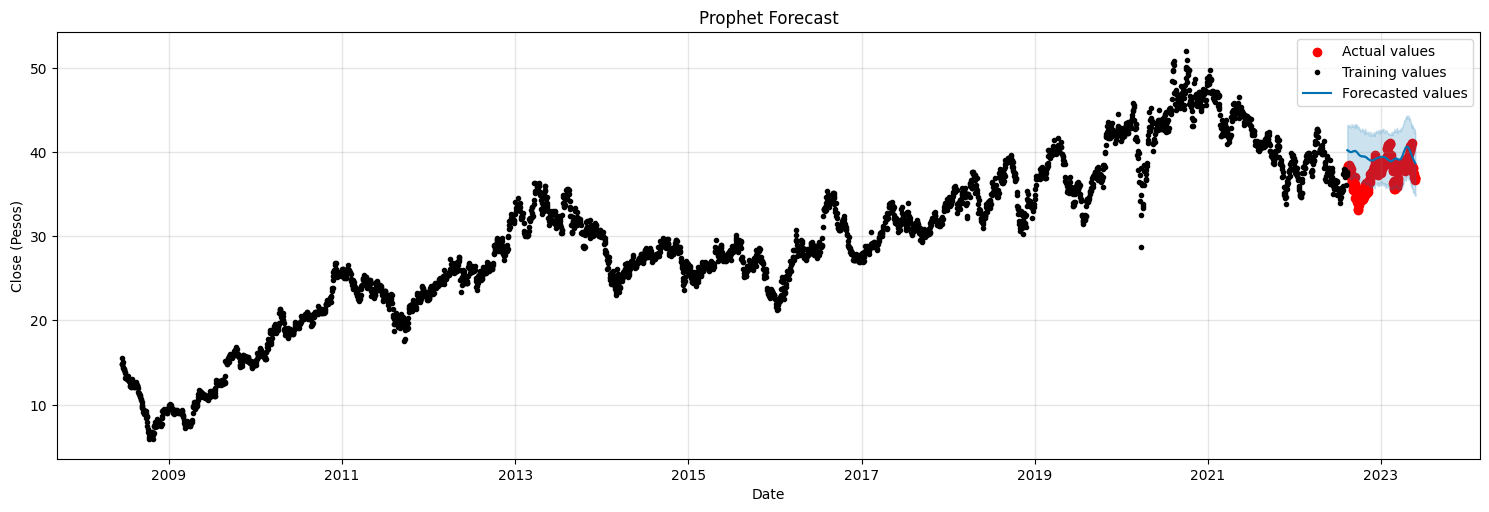

In [ ]:
# Plot the forecast with the Actual values

f, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_data["date"], test_data["close"], color='r')

fig = covid_model.plot(forecasted_close_data, ax=ax)

ax.set_title("Prophet Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Close (Pesos)")

ax.legend(["Actual values", "Training values", "Forecasted values"])

## Holidays

In [ ]:

def make_holiday(holiday_name, day, month, start_year, end_year):
  holidays = []

  for year in range(int(start_year), int(end_year) + 1):
    holidays.append(f"{year}-{month}-{day}")

  df = pd.DataFrame({
  "holiday": holiday_name,
  "ds": pd.to_datetime(holidays)
  })

  return df

# HOLIDAYS ARE INCLUDED WITHIN THE MIN AND MAX DATE IN THE DATASET (CHANGE IF WE ADD MORE DATA)

# Official days

new_year = make_holiday("new_year", "01", "01", "1990", "2023")

constitution_day = make_holiday("constitution_day", "06", "02", "1990", "2023")

benito_juarez = make_holiday("benito_juarez", "20", "03", "1990", "2023")

work_day = make_holiday("work_day", "01", "05", "1990", "2023")

independence_day = make_holiday("independence_day", "16", "09", "1990", "2022")

revolution_day = make_holiday("revolution_day", "20", "11", "1990", "2022")

christmas = make_holiday("christmas", "25", "12", "1990", "2022")

# Non-official days

holy_thursday = make_holiday("holy_thursday", "06", "04", "1990", "2023")

holy_friday = make_holiday("holy_friday", "07", "04", "1990", "2023")

battle_of_puebla = make_holiday("battle_of_puebla", "05", "05", "1990", "2023")

columbus_day = make_holiday("columbus_day", "12", "10", "1990", "2022")

day_of_the_dead = make_holiday("day_of_the_dead", "02", "11", "1990", "2022")

holy_mary_day = make_holiday("holy_mary_day", "12", "12", "1990", "2022")


holidays = {
    "new_year": new_year,
    "constitution_day": constitution_day,
    "benito_juarez": benito_juarez,
    "work_day": work_day,
    "independence_day": independence_day,
    "revolution_day": revolution_day,
    "christmas": christmas,
    "holy_thursday": holy_thursday,
    "holy_friday": holy_friday,
    "battle_of_puebla": battle_of_puebla,
    "columbus_day": columbus_day,
    "day_of_the_dead": day_of_the_dead,
    "holy_mary_day": holy_mary_day
}


In [ ]:
def get_holidays_df(included_holidays, holidays_dict):
  df = pd.DataFrame({"holiday": [], "ds" : []})

  for holiday in included_holidays:
    holiday_df = holidays_dict.get(holiday)

    df = pd.concat([df, holiday_df]).reset_index(drop=True)

  return df


In [ ]:
included_holidays = [
    "new_year",
    "constitution_day",
    "benito_juarez",
    "work_day",
    "independence_day",
    "revolution_day",
    "christmas",
    "holy_thursday",
    "holy_friday",
    "battle_of_puebla",
    "columbus_day",
    "day_of_the_dead",
    "holy_mary_day"
]

holidays_df = get_holidays_df(included_holidays, holidays)

In [ ]:
holidays_df.head()


,holiday,ds
0,new_year,1990-01-01
1,new_year,1991-01-01
2,new_year,1992-01-01
3,new_year,1993-01-01
4,new_year,1994-01-01


In [ ]:
holidays_model = Prophet(holidays=holidays_df)


In [ ]:
train_data_prophet = train_data_prophet[["ds", "y"]]

test_data_prophet = test_data_prophet[["ds", "y"]]

In [ ]:
holidays_model.fit(train_data_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnpn56mrv/8mku8h75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnpn56mrv/y7j6mtj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14256', 'data', 'file=/tmp/tmpnpn56mrv/8mku8h75.json', 'init=/tmp/tmpnpn56mrv/y7j6mtj4.json', 'output', 'file=/tmp/tmpnpn56mrv/prophet_model4zj8sc9d/prophet_model-20230606031713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:17:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:17:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
predicted_data = holidays_model.predict(test_data_prophet)

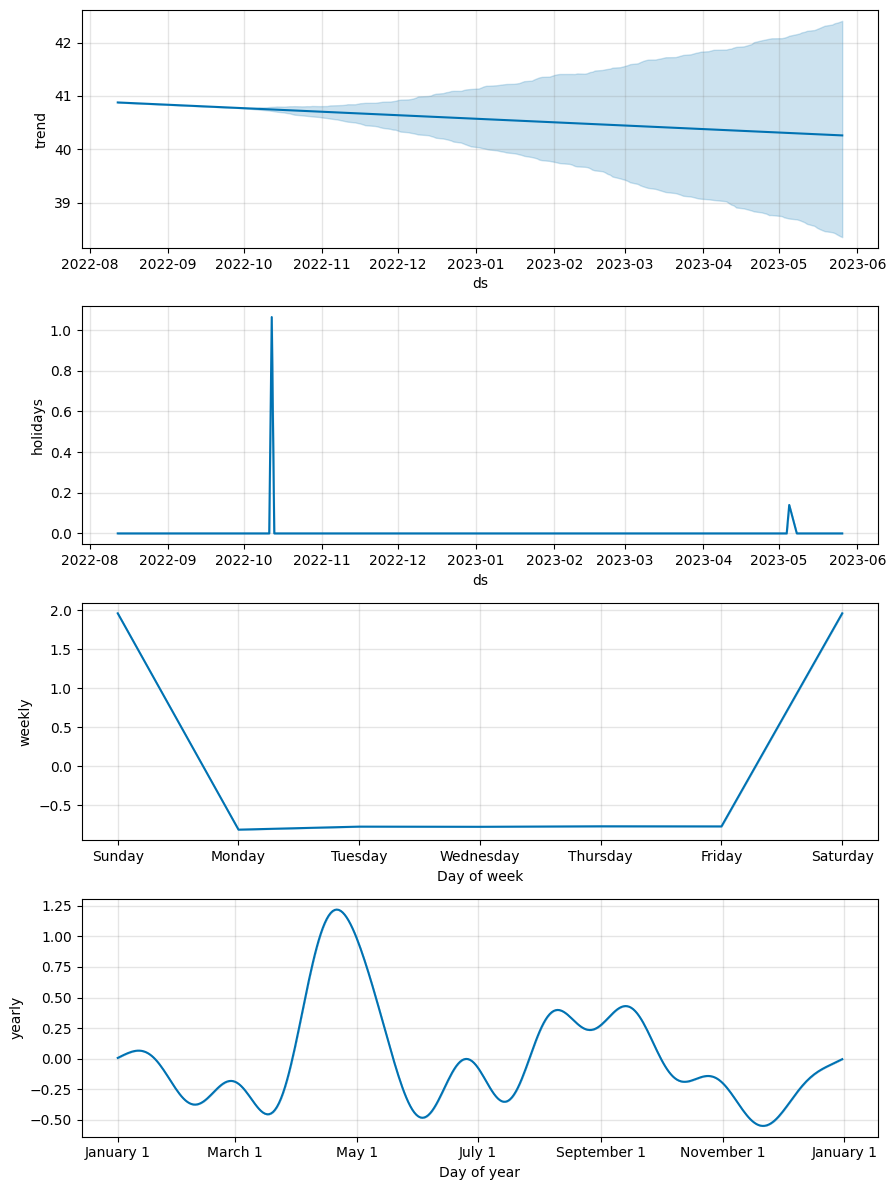

In [ ]:
fig = holidays_model.plot_components(predicted_data)

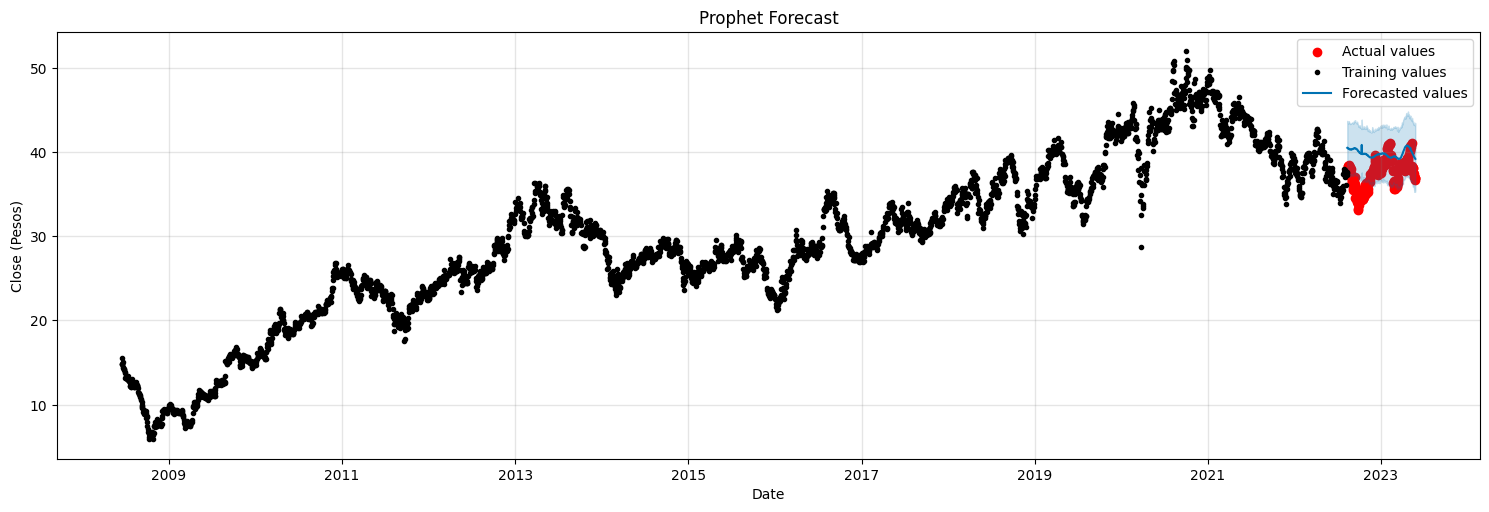

In [ ]:
# Plot the forecast with the real values

f, ax = plt.subplots(figsize=(15, 5))

ax.scatter(test_data["date"], test_data["close"], color='r')

fig = holidays_model.plot(predicted_data, ax=ax)

ax.set_title("Prophet Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Close (Pesos)")

ax.legend(["Actual values", "Training values", "Forecasted values"])

In [ ]:
print(holidays_df.sort_values("ds"))

              holiday         ds
0            new_year 1990-01-01
34   constitution_day 1990-02-06
68      benito_juarez 1990-03-20
235     holy_thursday 1990-04-06
269       holy_friday 1990-04-07
..                ...        ...
101     benito_juarez 2023-03-20
268     holy_thursday 2023-04-06
302       holy_friday 2023-04-07
135          work_day 2023-05-01
336  battle_of_puebla 2023-05-05

[436 rows x 2 columns]
